# Lab 2: CGANs on CIFAR-10

In [1]:
from __future__ import print_function, division
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Reshape, Concatenate
from tensorflow.keras.layers import BatchNormalization, Activation, Conv2D, Conv2DTranspose, LeakyReLU, ReLU, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import cifar10, mnist
from keras.preprocessing import image
import keras.backend as K
import matplotlib.pyplot as plt
import sys
import numpy as np
import time
from tqdm import tqdm

%matplotlib inline

## Parameters

In [ ]:
BATCH_SIZE = 16
EPOCHS = 100

NOISE_DIM = 100 
NUM_CLASSES = 10
tags = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

IMG_SIZE = 32

In [ ]:
# Helper function to plot generated images
def show_samples(num_samples, NUM_CLASSES, g_model):
    fig, axes = plt.subplots(10,num_samples, figsize=(10,20)) 
    fig.tight_layout()
    fig.subplots_adjust(wspace=None, hspace=0.2)

    for l in np.arange(10):
      random_noise = tf.random.normal(shape=(num_samples, NOISE_DIM))
      label = tf.ones(num_samples)*l
      gen_imgs = g_model.predict([random_noise, label])
      for j in range(gen_imgs.shape[0]):
        img = image.array_to_img(gen_imgs[j], scale=True)
        axes[l,j].imshow(img)
        axes[l,j].yaxis.set_ticks([])
        axes[l,j].xaxis.set_ticks([])

        if j ==0:
          axes[l,j].set_ylabel(tags[l])
    plt.show()

## Loading Data

In [ ]:
(X_train, y_train), (_, _) = cifar10.load_data()

# Normalize data
X_train = (X_train - 127.5) / 127.5
print (f"Train Shape: ({X_train.shape}, {y_train.shape})")
 
# Create tf.data.Dataset
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
dataset = dataset.shuffle(buffer_size=1000).batch(BATCH_SIZE)

Train Shape: ((50000, 32, 32, 3), (50000, 1))


Text(0.5, 1.0, 'Bird')

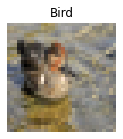

In [ ]:
plt.figure(figsize=(2,2))
idx = np.random.randint(0,len(X_train))
img = image.array_to_img(X_train[idx], scale=True)
plt.imshow(img)
plt.axis('off')
plt.title(tags[y_train[idx][0]])

## Loss and Optimizers

In [ ]:
bce_loss = tf.keras.losses.BinaryCrossentropy()

In [ ]:
# Discriminator Loss
def discriminator_loss(real_output, fake_output):
    real_loss = bce_loss(tf.ones_like(real_output), real_output)
    fake_loss = bce_loss(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
def generator_loss(d_predictions):
    return bce_loss(tf.ones_like(d_predictions), d_predictions)

In [ ]:
d_optimizer=Adam(learning_rate=0.0002, beta_1 = 0.5)
g_optimizer=Adam(learning_rate=0.0002, beta_1 = 0.5)

## Build Generator and Discriminator Architecture

In [ ]:
def build_generator():
    
  # label input
	in_label = Input(shape=(1,))  #Input of dimension 1
	# embedding for categorical input
  # each label (total 10 classes for cifar), will be represented by a vector of size 50. 
	li = Embedding(NUM_CLASSES, 50)(in_label) #Shape 1,50
    
	# linear multiplication
	n_nodes = 8 * 8  # To match the dimensions for concatenation later in this step.  
	li = Dense(n_nodes)(li) #1,64
	# reshape to additional channel
	li = Reshape((8, 8, 1))(li)
    
    
	# image generator input
	in_lat = Input(shape=(NOISE_DIM,))  #Input of dimension 100

	n_nodes = 128 * 8 * 8
	gen = Dense(n_nodes)(in_lat)  #shape=8192
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Reshape((8, 8, 128))(gen) #Shape=8x8x128
	# merge image gen and label input
	merge = Concatenate()([gen, li])  #Shape=8x8x129 (Extra channel corresponds to the label)
	# upsample to 16x16
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge) #16x16x128
	gen = LeakyReLU(alpha=0.2)(gen)
	# upsample to 32x32
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen) #32x32x128
	gen = LeakyReLU(alpha=0.2)(gen)
	# output
	out_layer = Conv2D(3, (8,8), activation='tanh', padding='same')(gen) #32x32x3
	# define model
	model = Model([in_lat, in_label], out_layer)
	return model   #Model not compiled as it is not directly trained like the discriminator.

In [ ]:
g_model = build_generator()
g_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense_5 (Dense)                (None, 8192)         827392      ['input_6[0][0]']                
                                                                                                  
 embedding_2 (Embedding)        (None, 1, 50)        500         ['input_5[0][0]']                
                                                                                            

In [ ]:
def build_discriminator():
    
  # label input
  in_label = Input(shape=(1,))  #Shape 1
  # embedding for categorical input
  #each label (total 10 classes for cifar), will be represented by a vector of size 50. 
  #This vector of size 50 will be learnt by the discriminator
  li = Embedding(NUM_CLASSES, 50)(in_label) #Shape 1,50
  # scale up to image dimensions with linear activation
  n_nodes = IMG_SIZE * IMG_SIZE  #32x32 = 1024. 
  li = Dense(n_nodes)(li)  #Shape = 1, 1024
  # reshape to additional channel
  li = Reshape((IMG_SIZE, IMG_SIZE, 1))(li)  #32x32x1


  # image input
  in_image = Input(shape=(IMG_SIZE, IMG_SIZE, 3)) #32x32x3
  # concat label as a channel
  merge = Concatenate()([in_image, li]) #32x32x4 (4 channels, 3 for image and the other for labels)

  # downsample: This part is same as unconditional GAN upto the output layer.
  #We will combine input label with input image and supply as inputs to the model. 
  fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge) #16x16x128
  fe = LeakyReLU(alpha=0.2)(fe)
  # downsample
  fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe) #8x8x128
  fe = LeakyReLU(alpha=0.2)(fe)
  # flatten feature maps
  fe = Flatten()(fe)  #8192  (8*8*128=8192)
  # dropout
  fe = Dropout(0.4)(fe)
  # output
  out_layer = Dense(1, activation='sigmoid')(fe)  #Shape=1

  # define model
  ##Combine input label with input image and supply as inputs to the model. 
  model = Model([in_image, in_label], out_layer)
      
  return model

In [ ]:
d_model = build_discriminator()
d_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 1, 50)        500         ['input_7[0][0]']                
                                                                                                  
 dense_6 (Dense)                (None, 1, 1024)      52224       ['embedding_3[0][0]']            
                                                                                                  
 input_8 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                            

## Train the GAN

In [ ]:
# Compiles the train_step function into a callable TensorFlow graph
# Also speeds up the training time
@tf.function
def train_step(dataset):
   
    real_images, real_labels = dataset
    # Sample random points in the latent space and concatenate the labels.
    random_latent_vectors = tf.random.normal(shape=(BATCH_SIZE, NOISE_DIM))
    generated_images = g_model([random_latent_vectors, real_labels])
    # print(np.amax(generated_images.numpy()), np.amin(generated_images.numpy()))

    # Train the discriminator.
    with tf.GradientTape() as tape:
        pred_fake = d_model([generated_images, real_labels])
        pred_real = d_model([real_images, real_labels])
        
        d_loss = discriminator_loss(pred_real, pred_fake)
      
    grads = tape.gradient(d_loss, d_model.trainable_variables)
    # print(grads)
    d_optimizer.apply_gradients(zip(grads, d_model.trainable_variables))

    #-----------------------------------------------------------------#
    
    # Sample random points in the latent space.
    random_latent_vectors = tf.random.normal(shape=(BATCH_SIZE, NOISE_DIM))
   
    # Train the generator (note that we should *not* update the weights
    # of the discriminator)!
    with tf.GradientTape() as tape:
        fake_images = g_model([random_latent_vectors, real_labels])
        # print(np.amax(fake_images.numpy()), np.amin(fake_images.numpy()))
        predictions = d_model([fake_images, real_labels])
        g_loss = generator_loss(predictions)
    
    grads = tape.gradient(g_loss, g_model.trainable_variables)
    # print(grads)
    g_optimizer.apply_gradients(zip(grads, g_model.trainable_variables))
    
    return d_loss, g_loss

In [ ]:
def train(dataset, epochs=EPOCHS):

    for epoch in range(EPOCHS):
        print('Epoch: ', epoch)
        d_loss_list = []
        g_loss_list = []
        q_loss_list = []
        start = time.time()
        
        itern = 0
        for image_batch in tqdm(dataset):
            d_loss, g_loss = train_step(image_batch)
            d_loss_list.append(d_loss)
            g_loss_list.append(g_loss)
            itern=itern+1
                
        show_samples(5, NUM_CLASSES, g_model)
            
        print (f'Epoch: {epoch} -- Generator Loss: {np.mean(g_loss_list)}, Discriminator Loss: {np.mean(d_loss_list)}\n')
        print (f'Took {time.time()-start} seconds. \n\n')

In [ ]:
train(dataset, epochs=EPOCHS)

Output hidden; open in https://colab.research.google.com to view.